In [1]:
import numpy as np
import scipy
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (14, 5)

# Energy-based Onset Detection

Sound is a vibration — a time-varying signal. The amplitude of the signal tells us how strong that vibration is at a given moment. But if we want to know how strong the signal is **over time**, we need a summary -- that is where 
two common measures for measuring just this come in: 'raw' energy, and root mean squared energy, or *RMSE*.

#### Analogy: Energy as "loudness" and/or "effort"

Think of energy like how much effort it takes to play a musical note. If you bang a drum hard, that’s high energy (and louder); if you tap it lightly, that’s low energy (and quieter).

The formula for the total **energy** of a discrete signal (or window) is defined by:

$$ \sum_n \left| x(n) \right|^2 $$

If we apply this over every $n$ (sample) in our discrete time signal, this corresponds to the *total* (sum) magntiude of the signal. This roughly corresponds to how loud a signal is. Note that we square the values before summing: this does two things:

* it ensures that we get rid of negative values (which would otherwise cancel out with the positive)
* it better aligns with human loudness perception.

#### RMS energy: the average magnitude of a signal

With RMSE, we have an averaging, we account for the number of values being summed by including a $\frac{1}{N}$ normalization factor prior to taking the square root. (I.e., we calculate the square *root* of the *mean* of the *squared* values!).

The **root-mean-square energy (RMSE)** in a signal is defined as

$$ \sqrt{ \frac{1}{N} \sum_n \left| x(n) \right|^2 } $$

* We average the squared values first.

* Then we take the square root to bring it back to the same unit as the signal amplitude.

* RMS is useful because it gives a consistent notion of signal strength — it’s more comparable across signals.

Notice that we could also calculate the energy after we have transformed to spectral energy. That is, the energy of a given time frame must be spread in some way across the frequency band (this is what we are measuring when we are measuring the magnitude spectrum). As such, if we simply summed over all the bands, we would know the total magnitude for that time frame. 


(Note, if you are *already* calculating other spectral features via a STFT procedure, you may wish to compute the energy or RMSE that way. However, for today, we will calculate energy directly from the discrete time signal.

### Clarifications: Magnitude vs. Amplitude vs. Energy

**Magnitude** typically refers to the size or strength of the signal *without any regard for direction* (polarity). In other words when we talk about the "magnitude of a signal" we are referring to values in absolute size. RMS is often described as the "average magnitude"

**Amplitude** can refer to either:
* the instantaneous value of the signal (e.g. voltage) at any given time, and
* the **maximum** value of the signal (peak amplitude)
More formally in *this* context, amplitude is the latter; the absolute value of the signal's peak at any point in time.

**Energy** refers to the "total amount" of signal strength over time.

Thus RMS is a time-averaged magnitude, while energy is the total accumulated magnitude over a period of time.



Let's load a signal:

In [2]:
#x, sr = librosa.load('../audio/CongaGroove-mono.wav')
(fs, x) = read('../audio/CongaGroove-mono.wav')

In [3]:
fs 

44100

In [4]:
x.shape

(192425,)

In [5]:
#make time array
dur = x.size/fs
time = np.arange(0, dur, 1/fs)
#normalize amplitude
xnorm = x/np.abs(x.max())

Listen to the signal:

In [6]:
Audio(x, rate=fs)

Plot the signal:

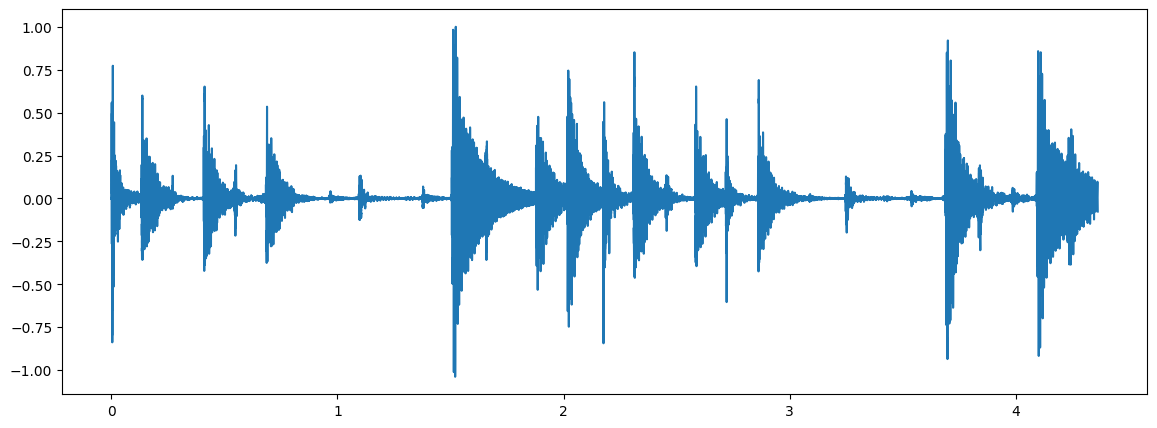

In [7]:
plt.plot(time, xnorm)

Let's compute both Energy and RMSE for sliding windows of 1024 samples. 

Notice that we do not have to choose a power of 2 anymore. However, when calculating multiple features (including spectral ones, where you *will* use power of 2) it is wise to examine the same slice (or collection) of samples.

All we have to do is implement the math into code:
$$ \sum_n \left| x(n) \right|^2 $$

In [8]:
# establish a frame size and hop size:

hop_length = 512 # 50% overlap
frame_length = 1024

#### Energy = Total squared energy in each frame:

In [9]:
energy = np.array([ # convert output from list comprehension into array
    
    # 1. grab one frame of samples at a time (i through i+frame_length)
    # 2. take the absolute value of the square of all the samples inside the frame, then sum
    # 3. increment by hop_length & repeat
    
    sum(abs(xnorm[i:i+frame_length]**2)) for i in range(0, len(xnorm), hop_length)
])

In [10]:
energy.shape

(376,)

In [11]:
energy[0]

71.35002392164817

#### RMS = average amplitude magnitude 

For now, we compute the RMS using [`librosa.feature.rms`](https://librosa.org/doc/latest/generated/librosa.feature.rms.html#librosa.feature.rms)

It has a handy function for converting the frame indices back to time values to align with the original input signal.

In [12]:
# note that the "y" argument is for time-series data input. It is no longer a positional argument.
rmse = librosa.feature.rms(y = xnorm, frame_length=frame_length, hop_length=hop_length, center=True)

In [13]:
rmse.shape

(1, 376)

Plot both the energy and RMSE along with the waveform:

In [14]:
frames = range(len(energy))

# create time array for frame values (for vizualizing)
t = librosa.frames_to_time(frames, sr=fs, hop_length=hop_length)

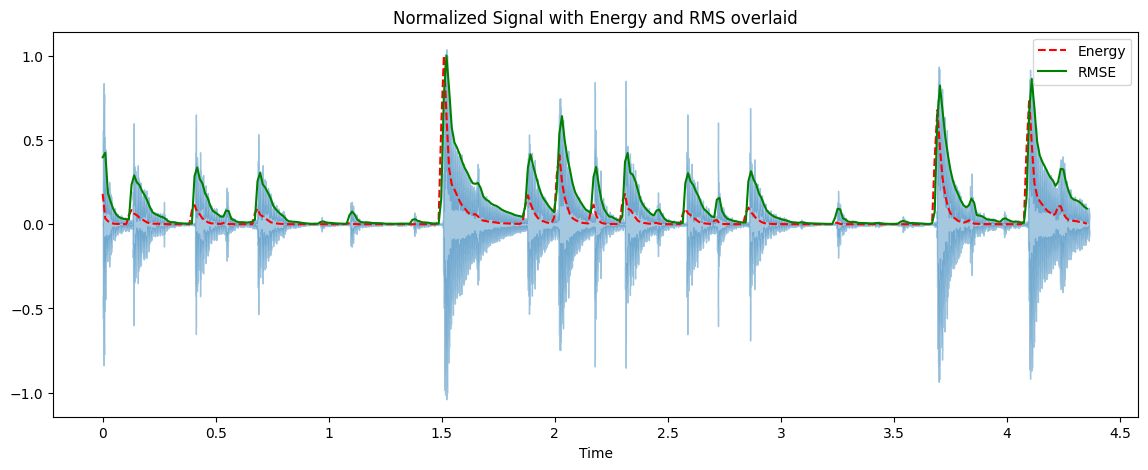

In [15]:
librosa.display.waveshow(xnorm, sr=fs, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--', label='Energy')       # normalized for visualization
plt.plot(t, rmse[0]/rmse[0].max(), color='g', label='RMSE')   # normalized for visualization
plt.title('Normalized Signal with Energy and RMS overlaid')
plt.legend()

This plot lets us **see energy peaks, which often correspond to onsets.** (When there's an onset, the energy increases rapidly). Notice that what we have done with the RMSE is plot the envelope of the signal!

Keep in mind: We have normalized the energy and RMS values independently here to simply show the location of the respective values and "fit" them on top of the signal. However, **this scaling ignores their original differences in magnitude** so while it affords one kind of visualization, it is partially obstructing the true dynamics of each feature.

#### Why we tend to use RMS in onset detection rather than energy:

RMS provides a normalized measure of the signal's magnitude (i.e., it accounts for the average power). It’s often preferred in analysis because it gives you a smoother representation of the signal’s energy, making it easier to compare between frames.

It is less sensitive to noise because of this smoothness, which can give "false alarms" for onset detection. 

Because of the normalization, it's also easier to compare *across* different frames and tracks, which makes it more consistent. RMSE gives you a measure that is independent of the overall amplitude scale of the signal.

### Converting the Raw Signal to a dB Scale & log_energy

#### Log Energy (10 × log10)
Energy (power) in dB: We use 10 × log10 because *energy is proportional to the square of the amplitude*. To compute log energy (in decibels), you use the formula: 

$$\text{log_energy} = 10 \times \log_{10}(\text{energy})$$

The factor of 10 comes from the logarithmic relationship between energy and power (which is proportional to amplitude squared). This is why we use 10 × log10 for energy.

#### Log Amplitude (20 × log10)
To convert our original signal (currently normalized -1 to 1) into dB, you use the formula:

$$\text{Amplitude-in-dB}=20 \times \log_{10}(\text{amplitude})$$



Amplitude in dB: We use 20 × log10 because amplitude is the square root of energy, and logarithms of square roots introduce the factor of 2 (making it 20 instead of 10).



The log scale is commonly used in signal processing to handle large variations in signal amplitude (like energy) because it compresses high values and expands low ones.

In this case, we can compare more easily energy and RMSE if we log-scale the energy:

The log scaling of the energy helps compress the wide range of energy values into a more manageable scale, making it easier to compare with other signals like RMSE. 

Here's another visualization of the earlier plot but with our energy log-scaled:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


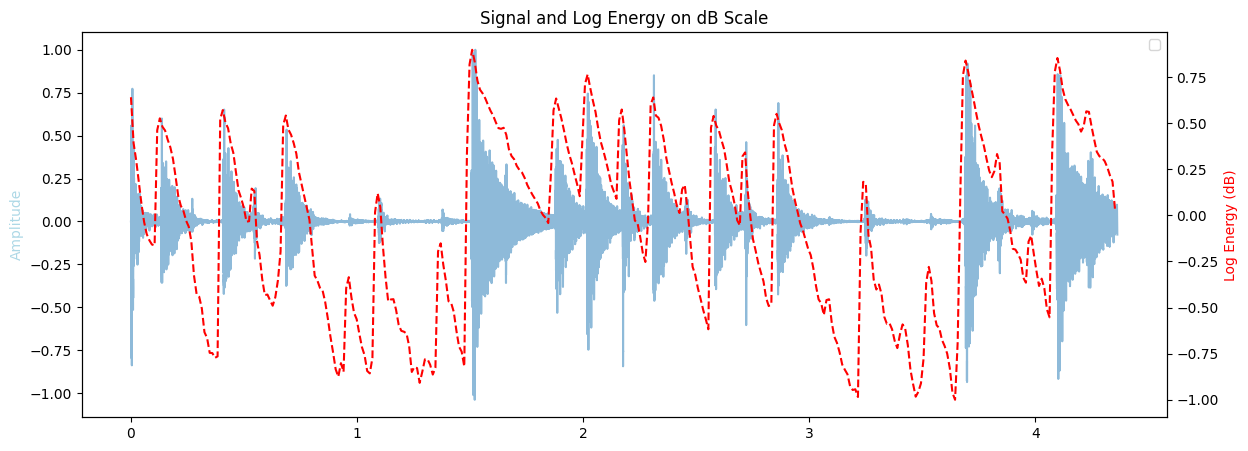

In [20]:

# convert energy to log energy (db)
log_energy = 10 * np.log10(energy + 1e-6)

# make subplots so you can have two different axes
# signal and energy on separate axes
fig, ax1 = plt.subplots()

time = np.arange(0,len(xnorm))/fs
ax1.plot(time, xnorm, alpha=0.5)
ax1.set_ylabel('Amplitude', color='lightblue')
ax2 = ax1.twinx()
ax2.plot(t, log_energy/max(abs(log_energy)), 'r--')
ax2.set_ylabel('Log Energy (dB)', color='r')


# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Log Energy (dB)')
plt.title('Signal and Log Energy on dB Scale')
plt.legend()

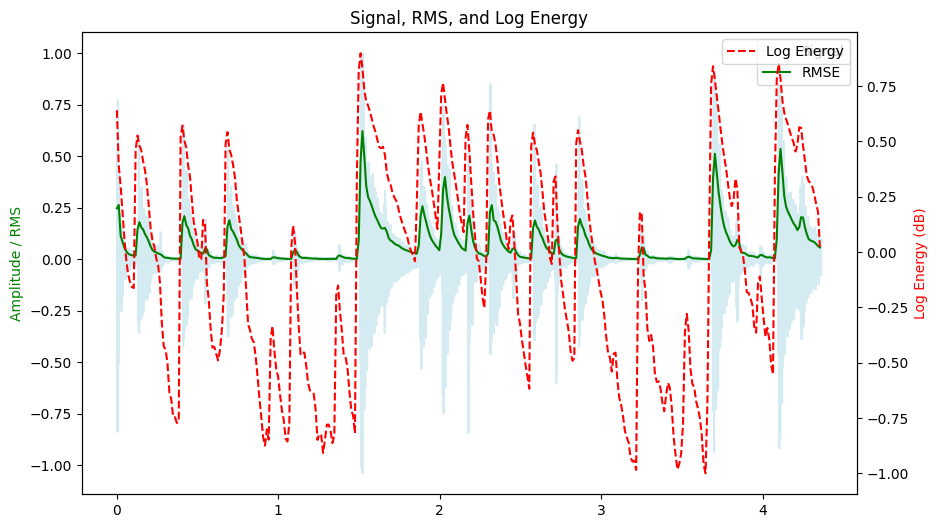

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Example data:
# Assuming you have xnorm (signal), energy, rms, t (time), and fs (sampling rate)

# Convert energy to log energy (dB)
log_energy = 10 * np.log10(energy + 1e-6)  # Add small epsilon to avoid log(0)

# Make subplots so you can have two different axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Time vector for plotting (assuming 't' is your time vector for energy)
time = np.arange(0, len(xnorm)) / fs  # Time for signal plotting

# Plot the signal on the first axis (left)
ax1.plot(time, xnorm, alpha=0.5, label="Signal", color='lightblue')
ax1.set_ylabel('Amplitude', color='lightblue')

# Plot the RMS on the same left axis (ax1)
ax1.plot(t, rmse[0], color='g', label="RMSE")  # You can choose a color for RMS
ax1.set_ylabel('Amplitude / RMS', color='g')

# Create a second axis (right) for the log energy
ax2 = ax1.twinx()
ax2.plot(t, log_energy / max(abs(log_energy)), 'r--', label="Log Energy")
ax2.set_ylabel('Log Energy (dB)', color='r')

# Add labels and title
plt.xlabel('Time (s)')
plt.title('Signal, RMS, and Log Energy')

# Add legends for both axes
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


## Some Definitions

**Attack** : sharp increase of energy

**Transient** : a short duration with high amplitude
within which signal evolves quickly

**Onset** : single instant marking the beginning of
transient. (Onsets frequently occur on beats.)

We have primarily until now been looking at *pitch-related* analysis tasks. Let us know consider *rhythm-related* analysis tasks. Here are a few:

* Onset detection
* Beat detection / beat tracking
* Tempo estimation

### Onset detection with Energy

One approach to onset detection is via the following procedure:

* Compute RMS (you may also try Energy or log Energy)
* Compute Derivative (differentiation) 
$\Delta E(n) = E(n+1) - E(n) $ 
* Perform half wave rectification (above or equal to zero; only energy increases are relevant for note onsets).
* Use a thresholding procedure where energy above some cutoff equals "1" (on) to identify onsets.


Notes: 
* log energy often better than linear energy
* Works best on tracks with percussion (true really of all onset detection methods!)

### Onset detection with Spectrum

An alternative approach uses spectral flux. Recall that spectral flux attempts to capture fast changing properties of the spectral content of the signal. Thus transients are well-captured with spectral flux.

* Compute STFT (optional: convert to log scale)
* Calculate spectral flux*
* Use thresholding procedure same as above.

Notes:

* less efficient & more complicated calculations (must sum over all frequency bins & use FFT)
* in some cases you may intentionally want to *only* sum over certain frequency bands (e.g., noise-like transient power will show up well above 1-2kHz)
* works slightly better for less percussive tracks with soft transients (e.g., legato notes, woodwinds, etc.)

### Tempo Estimation

How to estimate the tempo of a clip of music? We assume that onsets occur most frequently on beats, and beats are articulated more strongly and more frequently than off-beats, and should be approximately evenly spaced in time. (We also assume that the tempo is not changing for the purpose of this class!!)

Given this assumption, we need to examine the regularity or *periodicity* of the onsets. More on that next!